<a id="Title"></a>
# <span style="color:teal;font-weight:bold;">Spaceship Titanic 🔭 Aiming high</span>

This notebook is the continuation of my first exploration <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-getting-familiar/edit/run/191353629">Spaceship Titanic 🏁 Getting familiar</a>. There, I got a clear picture of the scoring expectation for this competition. Briefly, <span style="font-weight:bold;">I'm aiming for a score above 0.81, looking for a place among the top 5% submissions</span>.

In my previous work, I minimally processed the data and built simple Machine Learning models, achieving 0.79635 as the best score. This time, I <span style="font-weight:bold;">plan to thoroughly analyze the data, engineer features, correct missing values, find correlations, build ML models with different complexities and optimize their hyperparameters.</span>.

The methodology of this work is based on my previous notebook <a href="https://www.kaggle.com/code/fertmeneses/titanic-kaggle-full-analysis">Titanic/Kaggle -Full analysis</a> from the <span style="font-style:italic;">Titanic - Machine Learning from Disaster</span> competition.

<hr>

# <font color='teal'>Outline</font> <a class="anchor"  id="Outline"></a>

[**Data analysis**](#Data_analysis)

  - [Load original data](#Data_analysis_load)
  
  - [Distribution of values and transported rates](#Data_analysis_values_rates)
  
  - [Correlations (original data)](#Data_analysis_correlations)
  
[**Data edition**](#Data_edition)

  - [Feature engineering](#Feature_engineering)

    - ["Destination" redefinition](#DA_FE_Destination)

    - ["FromTo" new feature](#DA_FE_FromTo)

[**Machine Learning architectures**](#ML_architectures)

[**Hyperparameters optimization**](#Hyperparameters_optimization)
  
[**Conclusions**](#Conclusions)

<a id="Data_analysis"></a>
# <span style="color:teal;font-weight:bold;">Data analysis</span>

In this section, I load the original data and analyze it without any edition. This is the workflow:

- Load raw data.

- Analyze distribution of values and <span style="font-weight:bold;">Transported</span> rates.

- Analyze correlations. <span style="font-style:italic;">Note: for this step, I make a copy of the original dataset and One-Hot encode some features, but I don't use this copy for anything else.</span>

<a id="Data_analysis_load"></a>
## <span style="color:teal;font-weight:bold;">Load original data</span>

In the following lines, I load the original datasets and get this information:

- Example for 5 first rows in training dataset.

- Number of rows in both datasets.

- Features' names and data types.

- Number of missing values in both datasets, per feature and per row.

In [1]:
import pandas as pd
from termcolor import colored

# Load original datasets:
train_df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv') # Training dataset
test_df = pd.read_csv('kaggle/input/spaceship-titanic/test.csv') # Testing dataset
display(train_df.head(5)) # Examples
# Print global information:
print('\nNumber of rows in train/test datasets:\n')
print(len(train_df),'/',len(test_df))
print('\nFeatures: names and data types:\n')
print(train_df.dtypes)
# Print number of missing values per feature:
print('\nMissing values in train/test datasets:\n')
for col in test_df.columns:
    # Count missing values:
    N_train = train_df[col].isna().sum() 
    N_test = test_df[col].isna().sum()
    # Print results:
    color_train = 'red' if N_train else 'green'
    color_test = 'red' if N_test else 'green'
    rmargin = 40-len(col)
    print(f'{col}:',f'{colored(N_train, color_train)}/{colored(N_test, color_test)}'.rjust(rmargin))
# Count missing values in each row:
N_nan_train = train_df.apply(lambda x: x.isna().sum(), axis=1)
N_nan_test = test_df.apply(lambda x: x.isna().sum(), axis=1) 
# Print number of rows with N missing values:
for n in set(N_nan_train).union(set(N_nan_test)):
    print(f'Number of rows with {n} missing values: {sum(N_nan_train==n)}/{sum(N_nan_test==n)}')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



Number of rows in train/test datasets:

8693 / 4277

Features: names and data types:

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Missing values in train/test datasets:

PassengerId:         0/0
HomePlanet:       201/87
CryoSleep:        217/93
Cabin:           199/100
Destination:      182/92
Age:              179/91
VIP:              203/93
RoomService:      181/82
FoodCourt:       183/106
ShoppingMall:     208/98
Spa:             183/101
VRDeck:           188/80
Name:             200/94
Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1867/879
Number of rows with 2 missing values: 203/113
Number of rows with 3 missing values: 17/4


<a id="Data_analysis_values_rates"></a>
## <span style="color:teal;font-weight:bold;">Distribution of values and Transported rates</span>

For a better understanding of each feature, I <span style="font-weight:bold;">plot the distribution of values (column 1) in both training and testing datasets; and the Transported rates for the training dataset (column 2)</span>. Those feature with more than 10 unique values are not included in the plots.

In [96]:
# Define plotting functions:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_dist_pie(df_train,df_test,feature,axis):
    """
    Plots a pie chart for the distribution of values from a single
    feature in both training and testing datasets.
    --- Inputs ---
    {df_train, df_test} [Dataframes]: Training and testing datasets.
    Both datasets must include the column with the input name {feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    train_data, test_data = df_train[feature], df_test[feature]
    train_counts = train_data.value_counts().sort_index()
    test_counts = test_data.value_counts().sort_index()
    # Plot pie chart, start with the outer ring:
    axis.pie(train_counts, colors=sns.color_palette('tab20'),
             labels=train_counts.keys(),labeldistance=0.8,
             startangle=90,frame=True,explode=np.ones(len(train_counts))*0.01)
    # Add white ring to separate training and testing pies:
    axis.add_artist(plt.Circle((0,0),0.70,color='black', fc='white',linewidth=0))
    # Testing inner pie:
    axis.pie(test_counts, colors=sns.color_palette('tab20'),
             labels=None,labeldistance=0.6,
             radius=0.5,startangle=90,explode=np.ones(len(test_counts))*0.01)
    # Add white central circle to complete the pie:
    axis.add_artist(plt.Circle((0,0),0.25,color='black', fc='white',linewidth=0))
    # Set title:
    axis.set_title(f'{feature}: Distribution')
    
def plot_dist_hist(df_train,df_test,feature,axis,bin_step=None):
    """
    Plots a histogram chart for the distribution of values from a
    single feature in both training and testing datasets.
    --- Inputs ---
    {df_train, df_test} [Dataframes]: Training and testing datasets.
    Both datasets must include the column with the input name {feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    {bin_step} [Integer or None]: If provided, set the bins' 
    step-value for the histogram, otherwise automatically assigned.
    """
    # Identify relevant data and calculate fraction of valid values:
    train_data, test_data = df_train[feature], df_test[feature]
    train_frac = np.round(train_data.count()/len(train_data)*100,1) # [%]
    test_frac = np.round(test_data.count()/len(test_data)*100,1) # [%]
    # Determine binning, uniform for both datasets:
    min_range = min(min(train_data),min(test_data))
    max_range = max(max(train_data),max(test_data))
    if bin_step:
        binning = np.arange(min_range,max_range+bin_step*2,bin_step)-bin_step/2
    else:
        binning = np.linspace(min_range,max_range,10)
    # Bar plot:
    train_data.plot(kind='hist', bins=binning, edgecolor='navy', color='teal',
                    ax=axis, alpha=0.6)
    test_data.plot(kind='hist', bins=binning, edgecolor='navy', color='orange',
                   ax=axis, alpha=0.6)
    axis.legend(['Train','Test']) # Set legend   
    axis.set_yticks([0,int(axis.get_ylim()[1])], minor=False)
    axis.set_xlabel(feature)
    axis.set_title(f'{feature}: Distribution')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)

def plot_swarm(df_train,feature,axis,ref_feature='Transported',
               seed=42):
    """
    Plots a swarm plot ordered by the transported rate from a 
    single feature in the training dataset.
    --- Inputs ---
    {df_train} [Dataframe]: Training dataset, must include the
    columns with names {feature} and {ref_feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {ref_feature} [String]: Name of the column (feature) by which {feature} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    {seed} [Integer]: Seed for random scattering in swarm plots.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    train_data = df_train[feature] # Training dataset    
    train_counts = train_data.value_counts().sort_index()
    # For each variable, identify the transported rate and build the swarm plot:
    np.random.seed(seed) # Random seed for swarm plots
    for i, var in enumerate(train_counts.keys()):
        # Determine points' location:
        surv_rate = df_train.groupby([feature]).mean(numeric_only=True)[ref_feature].loc[var] # Transported rate
        pp_pos = int(len(df_train[(df_train[feature]==var)])*surv_rate) # Positive transported values
        pp_neg = int(len(df_train[(df_train[feature]==var)])*(1-surv_rate)) # Negative transported values
        var_pos = np.random.uniform(0, surv_rate,pp_pos) # Randomly assign locations for "positive" points
        var_neg = np.random.uniform(surv_rate,1,pp_neg) # Randomly assign locations for "negative" points              
        # Allocate all points in plot:
        color = np.array(sns.color_palette('tab20')[i])
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_neg)), var_neg,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     alpha=0.1, label=f'{var}({ref_feature}=0)')
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_pos)), var_pos,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     label=f'{var}({ref_feature}=1)')
        axis.plot([i-0.3,i+0.3],[surv_rate,surv_rate],ls='--',color='k',lw=1)
    # Ticks and limits:
    axis.set_xlim(-0.5, len(train_counts)-0.5)
    axis.set_ylim(-0.03, 1.1)
    if len(train_counts.keys())<5:
        axis.set_xticks(np.linspace(0,len(train_counts.keys())-1,len(train_counts.keys())))
        axis.set_xticklabels(train_counts.keys(), fontsize=10)
    else:
        axis.set_xticks([])
        axis.set_xticklabels([])
    axis.set_yticks([], minor=False)
    axis.set_ylabel('')
    # Spines, legend and title:
    for s in ["top","right","left", 'bottom']:
        axis.spines[s].set_visible(False)
    axis.legend([0,1],title=ref_feature,loc=(0.8, 0.7), edgecolor='k')
    axis.set_title(f'{feature}: "{ref_feature}" rate (Train)')

import warnings # <sns.kdeplot> gives a warning I couldn't fix, I avoid displaying it...
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_KDE(df_train,feature,axis,ref_feature='Transported'):
    """
    Plots a kernel density estimate (KDE) plot ordered by the 
    transported rate from a single feature in the training dataset.
    --- Inputs ---
    {df_train} [Dataframe]: Training dataset, must include the
    columns with names {feature} and {ref_feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {ref_feature} [String]: Name of the column (feature) by which {feature} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    """    
    train_data = df_train[feature] # Identify relevant data
    # Plot KDE:
    sns.kdeplot(x=feature, data=df_train, ax=axis, fill=True,cut=0,
                bw_method=0.15, lw=1.4, edgecolor='lightgray', hue=ref_feature,
                multiple="stack", palette='PuBu', alpha=0.8)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('Density [arb. units]')
    axis.set_title(f'{feature}: "{ref_feature}" rate (Train)')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)  

def explain_stats(df_train,feature,unique_vals_max=10):
    """
    Explains the distribution of values in a table format and the
    transported rates for the training dataset.
    --- Inputs ---
    {df_train} [Dataframe]: Training dataset, must include the
    columns with names {feature} and {ref_feature}.
    {feature} [String] Name of the column (feature) to be analyzed.
    {unique_vals_max} [Integer]: Maximum number of unique values 
    for the feature. If there are more than this limit, there 
    won't be any output table.
    """
    # Check the unique_vals_max condition (avoid NaN):
    unique_vals = {x for x in df_train[feature] if x == x} # Number of unique values
    if len(unique_vals) > unique_vals_max:
        print(f'There are {len(unique_vals)} unique values for this feature, more than the allowed limit ({unique_vals_max}).')
        return None    
    # Explained values:
    df_expl = pd.DataFrame(columns=[f'{feature}','#Passengers','Transported_Rate[%]'])
    df_expl[f'{feature}'] = sorted(unique_vals)
    df_expl['#Passengers'] = [len(df_train[df_train[f'{feature}'] == x])
                              for x in sorted(unique_vals)]
    # Transported rates for each feature category:
    df_expl['Transported_Rate[%]'] = [
        len(df_train[(df_train[feature] == x) & # Select fare range
            (df_train['Transported'] == 1)])/ # Passengers who were transported
        len(df_train[(df_train[feature] == x)]) # Total passengers
        for x in sorted(unique_vals) # Iterate through all feature categories
    ]
    df_expl['Transported_Rate[%]'] *=100 # Convert from fraction to [%]
    print(f'Explained {feature} values and transported rates in training dataset:')
    display(df_expl.style.hide())

---------- HomePlanet | Outer:train, Inner:test ----------


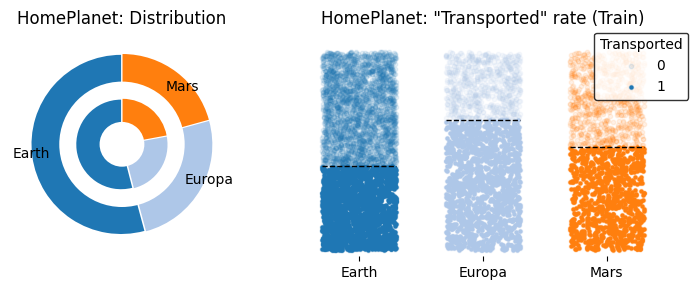

Explained HomePlanet values and transported rates in training dataset:


HomePlanet,#Passengers,Transported_Rate[%]
Earth,4602,42.394611
Europa,2131,65.884561
Mars,1759,52.302445


---------- CryoSleep | Outer:train, Inner:test ----------


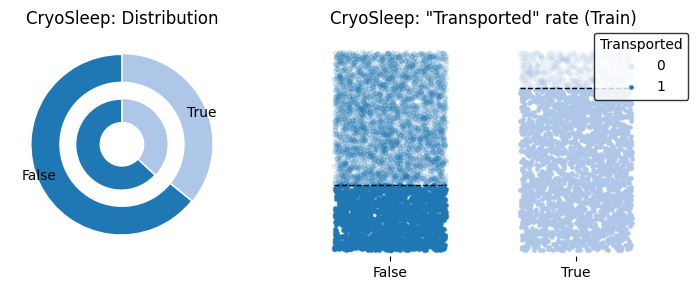

Explained CryoSleep values and transported rates in training dataset:


CryoSleep,#Passengers,Transported_Rate[%]
False,5439,32.892076
True,3037,81.758314


---------- Destination | Outer:train, Inner:test ----------


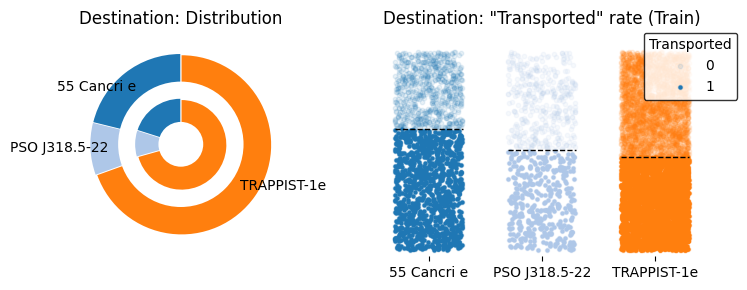

Explained Destination values and transported rates in training dataset:


Destination,#Passengers,Transported_Rate[%]
55 Cancri e,1800,61.000000
PSO J318.5-22,796,50.376884
TRAPPIST-1e,5915,47.117498


------------------------- Age -------------------------


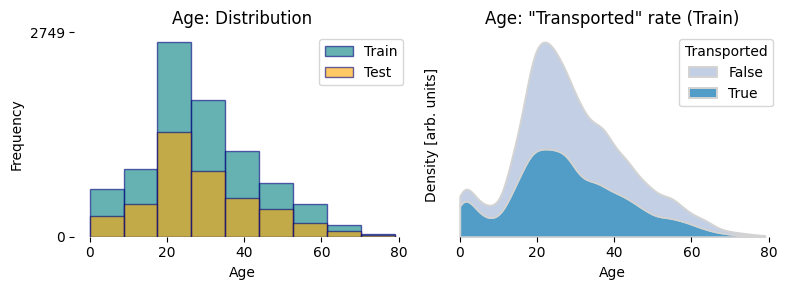

(Not suitable for a table)
---------- VIP | Outer:train, Inner:test ----------


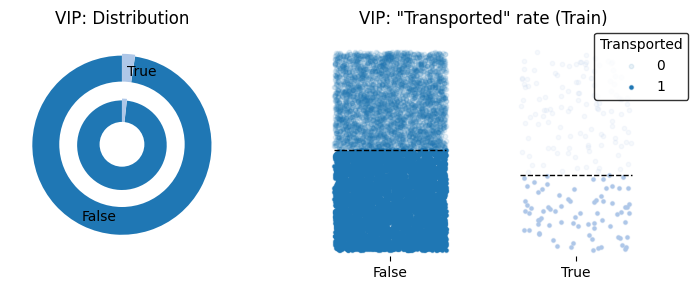

Explained VIP values and transported rates in training dataset:


VIP,#Passengers,Transported_Rate[%]
False,8291,50.633217
True,199,38.190955


------------------------- RoomService -------------------------


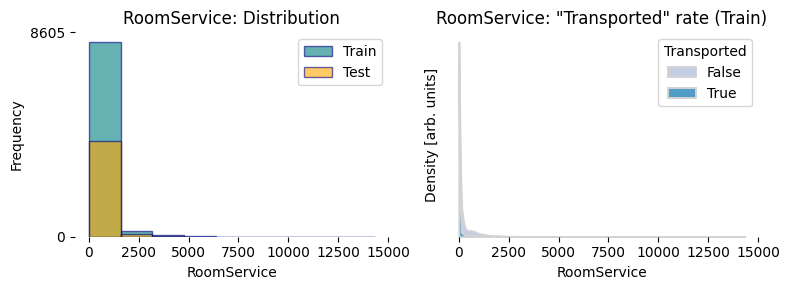

(Not suitable for a table)
------------------------- FoodCourt -------------------------


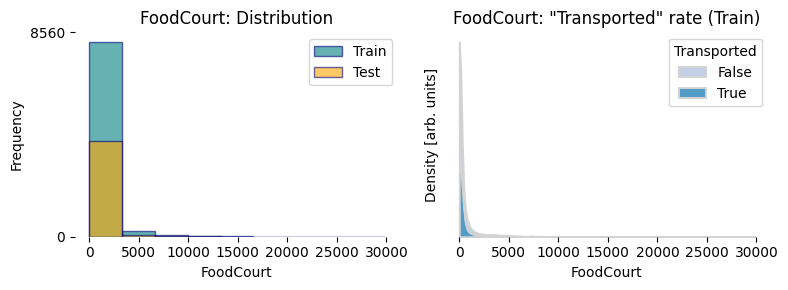

(Not suitable for a table)
------------------------- ShoppingMall -------------------------


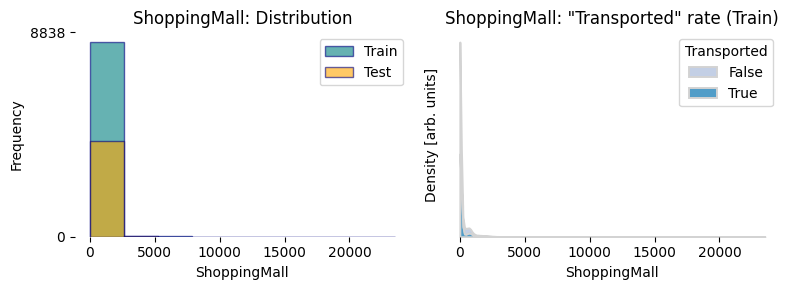

(Not suitable for a table)
------------------------- Spa -------------------------


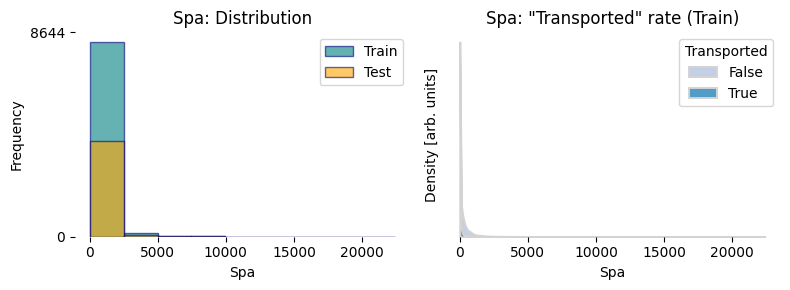

(Not suitable for a table)
------------------------- VRDeck -------------------------


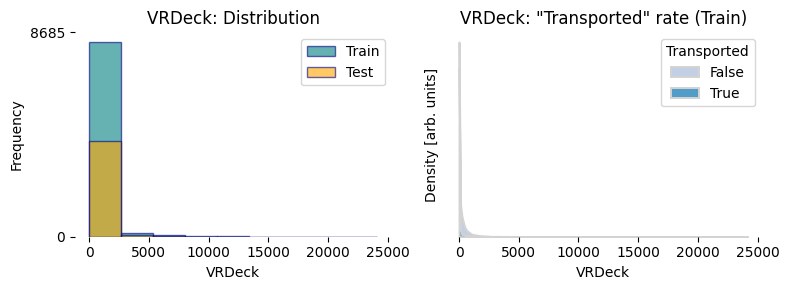

(Not suitable for a table)


In [97]:
# Select features to analyze:
features = [feat for feat in test_df.columns if 
            test_df[feat].dtype != 'object' or # Numeric or...
            test_df[feat].nunique()<10] # ...Few unique values

# Plot distribution of values and transported rates for each feature:
for feature in features:
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
    if train_df[feature].dtype == 'object': # Non-numerical features:
        print('-'*10,f'{feature} | Outer:train, Inner:test','-'*10)
        plot_dist_pie(train_df,test_df,feature,ax1)
        plot_swarm(train_df,feature,ax2)    
    else: # Numerical features:
        print('-'*25,feature,'-'*25)
        plot_dist_hist(train_df,test_df,feature,ax1)
        plot_KDE(train_df,feature,ax2)
    fig.tight_layout()
    plt.show()
    # Display explanatory table only if there are equal or less than 10 unique values:
    if len(set(train_df[feature]))<=10:
        explain_stats(train_df,feature)
    else:
        print('(Not suitable for a table)')

Summary about the distribution of values and transported rates:

| Feature | <font color=blue> Distribution </font> | <font color=green> Transported rates </font> |
| :---: | :--- | :--- |
| <span style="font-weight:bold;">HomePlanet</span> | <font color=blue> Half of the passengers come from Earth, 1/4 from Europa and 1/4 from Mars  </font> | <font color=green> Europa has a slightly good rate (65%), Mars average (50%) and Earth slightly poor (40%) </font> |
| <span style="font-weight:bold;">CryoSleep</span> | <font color=blue> Only 1/3 of passengers were in CryoSleep  </font> | <font color=green> Excellent chances (80%) if Cryosleep, poor (30%) if not </font> |
| <span style="font-weight:bold;">Destination</span> | <font color=blue> 2/3 of passengers were going to Trappist, 1/4 to Cancri and 10% to PSO </font> | <font color=green> Those going to Cancri have good chances (60%), the rest average (50%) </font> |
| <span style="font-weight:bold;">Age</span> | <font color=blue> From 0 to 80, peak around 20-30 </font> | <font color=green> Good chances for the very young (less than 10 years old?), maybe average for the rest </font> |
| <span style="font-weight:bold;">VIP</span> | <font color=blue> Only 200 passengers are VIP </font> | <font color=green> VIP passengers have slightly bad chances (40%) </font> |
| <span style="font-weight:bold;">RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</span> | <font color=blue> Only a few passengers spend more than a little money in services </font> | <font color=green> Can't tell from the plots </font> |

<a id="Data_analysis_correlations"></a>
## <span style="color:teal;font-weight:bold;">Correlations (original data)</span>

Next, I study the <span style="font-weight:bold;">correlations in the original data, using the training dataset, only for those features analyzed in the previous section</span>. I build a correlation matrix with a 0.1 threshold correlation value, then only high correlations are painted.

Note: the correlation matrix needs numerical or boolean features. For this purpose, I One-Hot encode the non-numerical features, and group family-encoded-features in dotted traingles within the correlation matrix (correlations there are irrelevant).

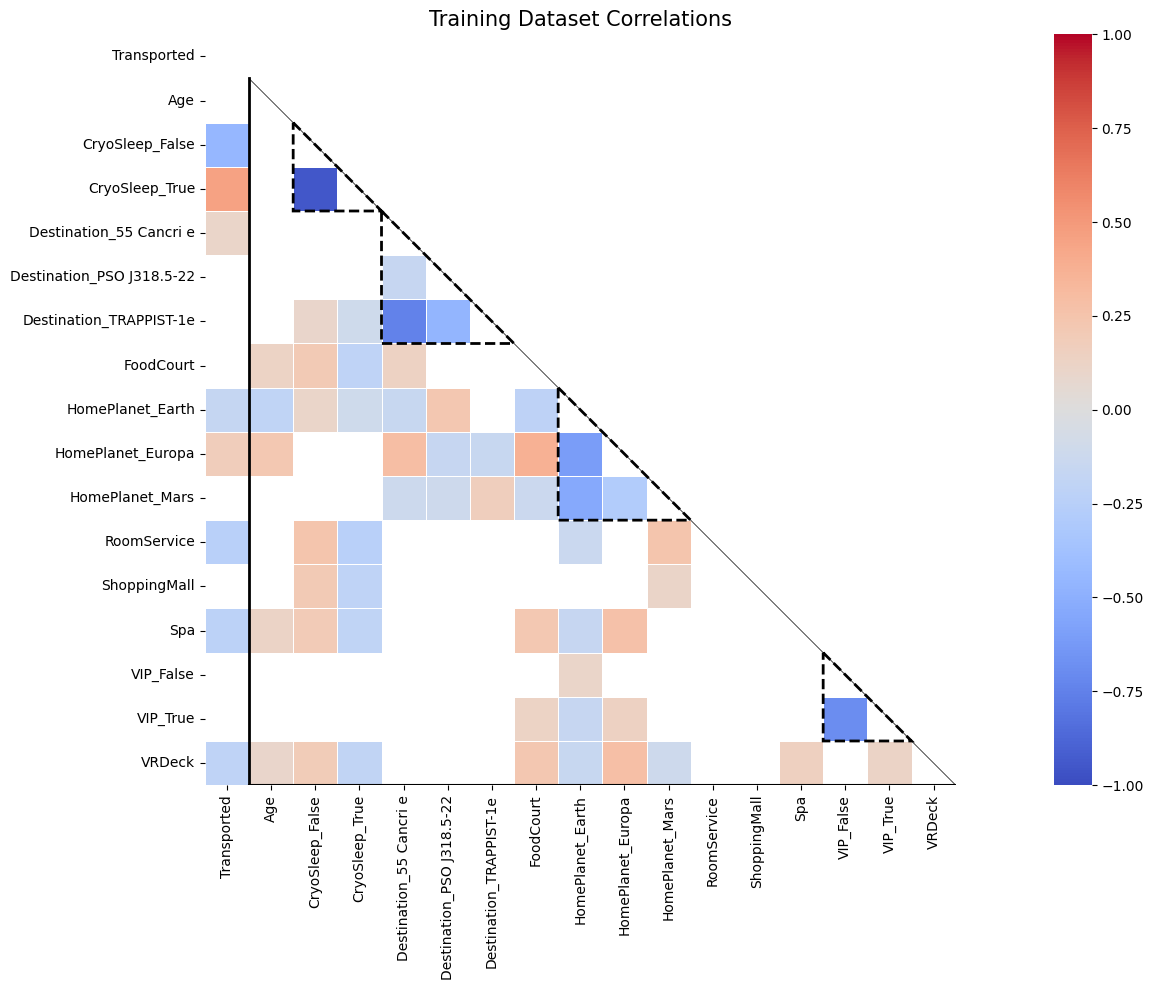

In [4]:
# One-Hot encode non-numerical features with few unique values:
feat_enc = [feat for feat in train_df.columns if 
            train_df[feat].dtype == 'object' and # Numeric or...
            train_df[feat].nunique()<10] # ...Few unique values

# Encode features:
data_train_enc = pd.get_dummies(train_df[feat_enc])
# Prepare dataframes having only numeric/boolean features:
train_df_enc = pd.concat([train_df, data_train_enc], axis=1)
# Sort columns alphabetically, but leave 'Transported' at the beggining in training dataset:
train_df_enc = train_df_enc.reindex(sorted(train_df_enc.columns), axis=1)
train_df_enc = train_df_enc[['Transported'] + [col for col in train_df_enc.columns
                                               if col != 'Transported' ]]
# Drop source-encoded features: 
train_df_enc = train_df_enc.drop(feat_enc,axis=1)
# Drop not suitable features:
feat_not_enc = [feat for feat in train_df.columns if
                train_df[feat].dtype == 'object' and # Numeric or...
                train_df[feat].nunique()>=10] # ...Few unique values
train_df_enc = train_df_enc.drop(feat_not_enc,axis=1)

import matplotlib.patches as patches

# Prepare data:
corr_train = train_df_enc.corr() # Obtain correlations
trimask = np.triu(np.ones_like(corr_train, dtype=bool)) # Mask upper triangle in correlations
c_thres = 0.1 # Threshold value to show correlations

fig, ax = plt.subplots(figsize=(20, 10))
# Plot correlations in training dataset:
sns.heatmap(corr_train, ax=ax, square=True, 
            cmap='coolwarm', vmin=-1, vmax=1,
            linecolor='w',lw=0.5, 
            mask=trimask | (np.abs(corr_train) <= c_thres))
# Separate the "Survived" correlations:
ax.plot([1,1],[1,len(train_df_enc.columns)],color='k',lw=2)
# Draw the correlations' triangle:
ax.plot([1,len(train_df_enc.columns)],[1,len(train_df_enc.columns)],color='k',lw=0.5)
ax.plot([1,len(train_df_enc.columns)],[len(train_df_enc.columns),len(train_df_enc.columns)],
        color='k',lw=1.5)
# Identify blocks of similar features:
main_name = [feat.split('_')[0] for feat in list(train_df_enc.columns)]
index_counts = [(main_name.index(name),main_name.count(name))
                for name in sorted(set(main_name))]
for index, counts in index_counts:
    if counts>1: 
        triangle = [[index, index],
                    [index+counts, index+counts],
                    [index, index+counts]]
        ax.add_patch(patches.Polygon(triangle, edgecolor="k",facecolor='none',ls="--",lw=2))
ax.set_title(f"Training Dataset Correlations", size=15)
fig.tight_layout()
plt.show()

I'm going to do a more detailed analysis later, but from this plot I highlight the following facts:

<span style="font-weight:bold;">Chances of transportation (first column):</span> 
- <span style="font-weight:bold;">CryoSleep</span>: Cryo-sleeping (True) is better.
- <span style="font-weight:bold;">Destination</span>: going to Cancri is better.
- <span style="font-weight:bold;">HomePlanet</span>: being from Earth is worse, from Europa is better. 
- <span style="font-weight:bold;">RoomService</span>: paying more is worse.
- <span style="font-weight:bold;">Spa</span>: paying more is worse.
- <span style="font-weight:bold;">VRDeck</span>: paying more is worse.

<span style="font-style:italic;">Note: the correlation matrix is strongly affected by the number of values with significant correlations, that's why the <span style="font-weight:bold;">VIP</span> feature is not painted, even though being VIP is an important indicator for Transportation. </span>

<span style="font-weight:bold;">Other observations (main triangle):</span>

- Cryo-sleeping passengers spend less in services 
(<span style="font-weight:bold;">FoodCourt</span>
<span style="font-weight:bold;">RoomService</span>, 
<span style="font-weight:bold;">ShoppingMall</span>,
<span style="font-weight:bold;">Spa</span>,
<span style="font-weight:bold;">VRDeck</span>).
- The older the passenger, the more more likely is that they are from Europa. On the contrary, younger passengers are more likely to come from Earth.
- The following origin-destinations are more probable: Europa-Cancri, Earth-PSO, Mars-Trappist.
- Passengers from Mars are more likely to spend more in RoomService and ShoppingMall.
- Passengers from Europa are more likely to spend more in Spa and VRDeck.

<a id="Data_edition"></a>
# <span style="color:teal;font-weight:bold;">Data edition</span>

In this section, I <span style="font-weight:bold;">engineer features first and then correct missing values</span>. This sequence is not very usual, but my plan is to <span style="font-weight:bold;">correct the missing values by data imputation</span>, meaning that a Supervised Machine Learning algorithm will predict the missing values based on the other features. For this reason, I will refine the features as much as possible, encode them so they are suitable for a ML model, and only then correct the dataset.

<a id="Feature_engineering"></a>
## <span style="color:teal;font-weight:bold;">Feature engineering</span>

There will be many new and modified features along this process. The objective is to <span style="font-weight:bold;">generate new information combining two or more features, or extract/separate information from a single feature</span>. 

By the end of the data engineering process, each feature in the dataset should be numeric, boolean, or non-numeric with a few unique values (so it can be easily encoded).

In [5]:
# First generate the corrected datasets:
train_df_corr = train_df.copy()
test_df_corr = test_df.copy()

<a id="DA_FE_Destination"></a>
### <span style="color:teal;font-weight:bold;">"Destination" redefinition</span>

The current <span style="font-weight:bold;">Destination</span> feature's unique values are hard to read: '55 Cancri e', 'PSO J318.5-22' and 'TRAPPIST-1e'. I redefine them as 'Cancri', 'PSO' and "Trappist', respectively.

In [6]:
train_df_corr["Destination"] = train_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)
test_df_corr["Destination"] = test_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)

<a id="DA_FE_FromTo"></a>
### <span style="color:teal;font-weight:bold;">"FromTo" new feature</span>

In the Titanic voyage, <span style="font-weight:bold;">the itinerary for any passenger can be defined by their HomePlanet feature and Destination</span>. Possibilities are limited: from [Earth, Europa, Mars] to [Cancri, PSO, Trappist].

<span style="font-weight:bold;">I will create a new feature called FromTo, containing strings with the format "{HomePlanet}-{Destination}".</span> 

<span style="font-style:italic;">Note: Any missing value in either <span style="font-weight:bold;">HomePlanet</span> or <span style="font-weight:bold;">Destination</span> will be translated in a missing value in <span style="font-weight:bold;">FromTo</span>.</span>

In [99]:
# Define feature:
for dataset in [train_df_corr, test_df_corr]:
    dataset["FromTo"] = dataset["HomePlanet"] + '-' + dataset["Destination"]

----------  FromTo | Outer:train, Inner:test ----------


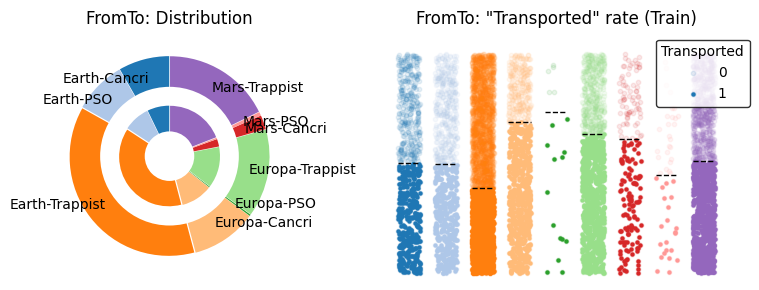

Explained FromTo values and transported rates in training dataset:


FromTo,#Passengers,Transported_Rate[%]
Earth-Cancri,690,50.434783
Earth-PSO,712,49.859551
Earth-Trappist,3101,38.922928
Europa-Cancri,886,68.961625
Europa-PSO,19,73.684211
Europa-Trappist,1189,63.498738
Mars-Cancri,193,61.139896
Mars-PSO,49,44.897959
Mars-Trappist,1475,51.186441


In [100]:
# Plot distribution of values and Transported rates:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
print('-'*10,f' FromTo | Outer:train, Inner:test','-'*10)
plot_dist_pie(train_df_corr,test_df_corr,"FromTo",ax1)
plot_swarm(train_df_corr,"FromTo",ax2)    
fig.tight_layout()
plt.show()
# Display explanatory table:
explain_stats(train_df_corr,"FromTo")

<a id="ML_architectures"></a>
# <span style="color:teal;font-weight:bold;">Machine Learning architectures</span>

Xxxx

<a id="Hyperparameters_optimization"></a>
# <span style="color:teal;font-weight:bold;">Hyperparameters optimization</span>

Xxxx

<a id="Conclusions"></a>
# <span style="color:teal;font-weight:bold;">Conclusions</span>

Xxxx